# First face mask prototype

## Packages

In [13]:
import json
import os
import random

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

from keras.models import Sequential, load_model
from keras import optimizers
from keras import backend as K
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

In [14]:
json_file_path = 'data/Medical mask/Medical mask/Medical Mask/annotations'
image_directory = 'data/Medical mask/Medical mask/Medical Mask/images'
df = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/submission.csv')

In [15]:
cvNet = cv2.dnn.readNetFromCaffe('data/face-detector-model/architecture.txt',
                                 'data/face-detector-model/weights.caffemodel')

In [17]:
def getJSON(filePathandName):
    with open(filePathandName,'r') as f:
        return json.load(f)
def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)])
    return cv2.LUT(image.astype(np.uint8), table.astype(np.uint8))

In [18]:
jsonfiles= []
for i in os.listdir(json_file_path):
    jsonfiles.append(getJSON(os.path.join(json_file_path,i)))
jsonfiles[0]

{'FileName': '1801.jpg',
 'NumOfAnno': 1,
 'Annotations': [{'isProtected': False,
   'ID': 924868908868875136,
   'BoundingBox': [451, 186, 895, 697],
   'classname': 'face_no_mask',
   'Confidence': 1,
   'Attributes': {}}]}

In [19]:
df.head()

,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask


In [20]:
pd.unique(df.classname)

array(['face_with_mask', 'mask_colorful', 'face_no_mask',
       'face_with_mask_incorrect', 'mask_surgical', 'face_other_covering',
       'scarf_bandana', 'eyeglasses', 'helmet', 'face_shield',
       'sunglasses', 'hood', 'hat', 'goggles', 'hair_net', 'hijab_niqab',
       'other', 'gas_mask', 'balaclava_ski_mask', 'turban'], dtype=object)

In [21]:
selected_classnames = ['face_with_mask', 'face_no_mask']
df_selected = df.loc[df.classname.isin(selected_classnames)]

<AxesSubplot:>

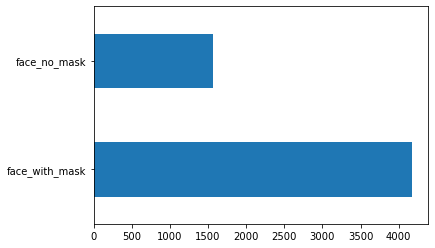

In [22]:
df_selected.classname.value_counts().plot(kind='barh', rot=0)

In [23]:
data = []
img_size = 124
mask = ['face_with_mask']
non_mask = ['face_no_mask']
labels={'face_with_mask':0,'face_no_mask':1}
for picture_name in tqdm(df['name'].unique()):
    file = f'{picture_name}.json'
    for j in getJSON(os.path.join(json_file_path,file)).get('Annotations'):
        if j['classname'] in mask:
            x,y,w,h = j['BoundingBox']
            img = cv2.imread(os.path.join(image_directory, picture_name),1)
            img = img[y:h,x:w]
            img = cv2.resize(img,(img_size,img_size))
            data.append([img,labels['face_with_mask']])
        if j['classname'] in non_mask:
            x,y,w,h = j['BoundingBox']
            img = cv2.imread(os.path.join(image_directory, picture_name),1)
            img = img[y:h,x:w]
            img = cv2.resize(img,(img_size,img_size))    
            data.append([img,labels['face_no_mask']])
random.shuffle(data)

100%|██████████| 4326/4326 [02:13<00:00, 32.38it/s]


In [24]:
X = []
Y = []
for features,label in data:
    X.append(features)
    Y.append(label)

X = np.array(X)/255.0
X = X.reshape(-1,124,124,3)
Y = np.array(Y)

In [26]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape=(124,124,3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam' ,metrics=['accuracy'])
xtrain,xval,ytrain,yval=train_test_split(X, Y,train_size=0.8,random_state=0)

datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,    
        rotation_range=15,    
        width_shift_range=0.1,
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=False)

datagen.fit(xtrain)

history = model.fit(datagen.flow(xtrain, ytrain, batch_size=32),
                    epochs=20,
                    verbose=1,
                    validation_data=(xval, yval))

Epoch 1/20
144/144 [==============================] - 478s 3s/step - loss: 0.4582 - accuracy: 0.7960 - val_loss: 0.2974 - val_accuracy: 0.9000
Epoch 2/20
144/144 [==============================] - 667s 5s/step - loss: 0.3169 - accuracy: 0.8667 - val_loss: 0.2793 - val_accuracy: 0.9000
Epoch 3/20
144/144 [==============================] - 449s 3s/step - loss: 0.3420 - accuracy: 0.8508 - val_loss: 0.2647 - val_accuracy: 0.9113
Epoch 4/20
144/144 [==============================] - 543s 4s/step - loss: 0.3049 - accuracy: 0.8787 - val_loss: 0.2557 - val_accuracy: 0.9139
Epoch 5/20
144/144 [==============================] - 553s 4s/step - loss: 0.2992 - accuracy: 0.8800 - val_loss: 0.2334 - val_accuracy: 0.9096
Epoch 6/20
144/144 [==============================] - 413s 3s/step - loss: 0.2847 - accuracy: 0.8824 - val_loss: 0.2786 - val_accuracy: 0.9235
Epoch 7/20
144/144 [==============================] - 419s 3s/step - loss: 0.2849 - accuracy: 0.8915 - val_loss: 0.2466 - val_accuracy: 0.9026

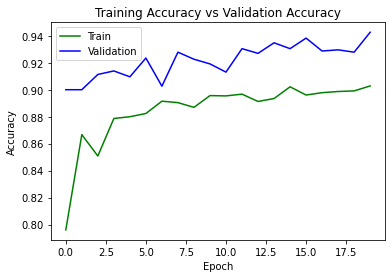

In [27]:
plt.plot(history.history['accuracy'],'g')
plt.plot(history.history['val_accuracy'],'b')
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

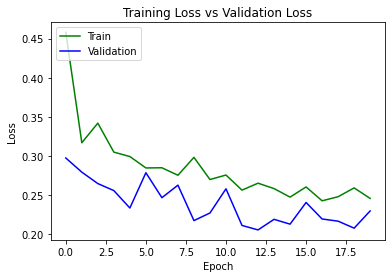

In [28]:
plt.plot(history.history['loss'],'g')
plt.plot(history.history['val_loss'],'b')
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [29]:
model.save("data/Mask_Detection_Model.h5")

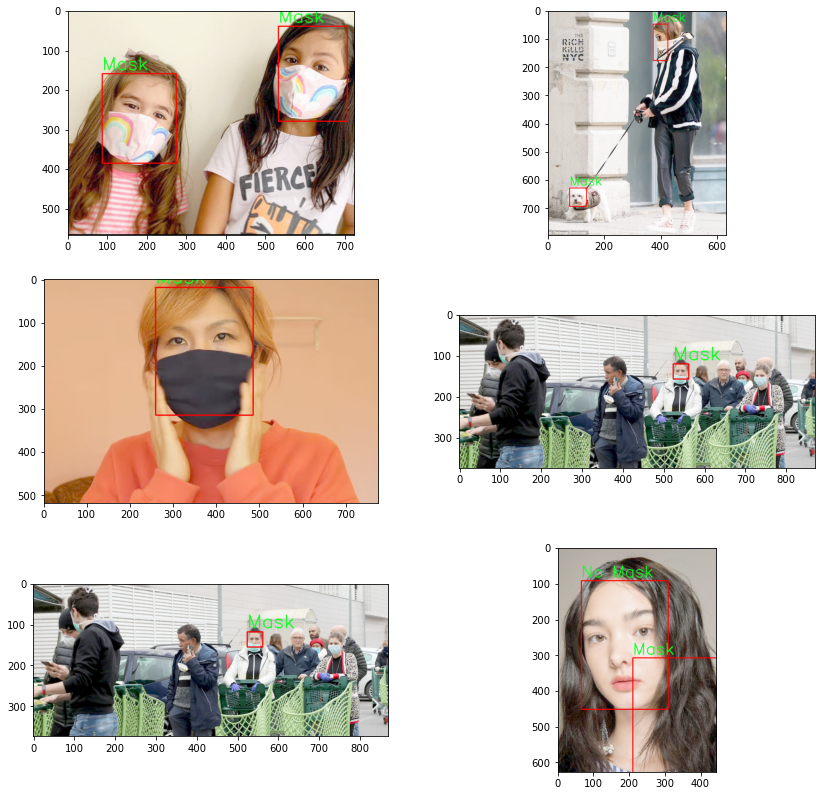

In [30]:
test_images = ['2756.png','5342.jpg', '4591.png','3939.png','3939.png','3911.png']

gamma = 2.0
fig = plt.figure(figsize = (14,14))
rows = 3
cols = 2
axes = []
assign = {'0':'Mask','1':"No Mask"}
for j,im in enumerate(test_images):
    image =  cv2.imread(os.path.join(image_directory,im),1)
    image =  adjust_gamma(image, gamma=gamma)
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300,300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    cvNet.setInput(blob)
    detections = cvNet.forward()
    for i in range(0, detections.shape[2]):
        try:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            frame = image[startY:endY, startX:endX]
            confidence = detections[0, 0, i, 2]
            if confidence > 0.2:
                im = cv2.resize(frame,(img_size,img_size))
                im = np.array(im)/255.0
                im = im.reshape(1,124,124,3)
                result = model.predict(im)
                if result>0.5:
                    label_Y = 1
                else:
                    label_Y = 0
                cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
                cv2.putText(image,assign[str(label_Y)] , (startX, startY-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (36,255,12), 2)
        
        except:pass
    axes.append(fig.add_subplot(rows, cols, j+1))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

In [31]:
model = load_model('data/Mask_Detection_Model.h5')

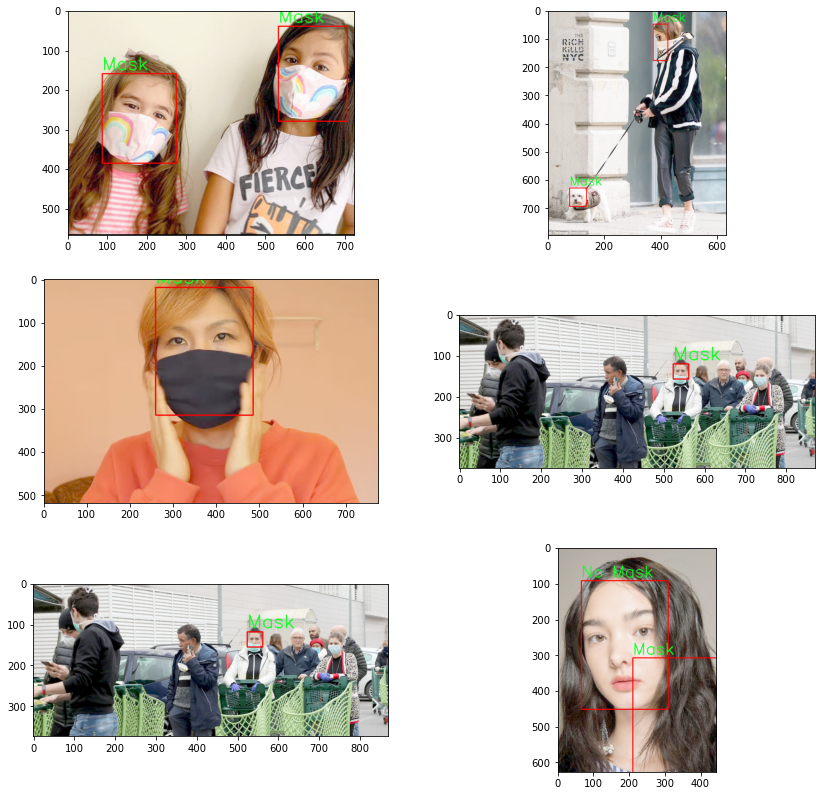

In [32]:
test_images = ['2756.png','5342.jpg', '4591.png','3939.png','3939.png','3911.png']

gamma = 2.0
fig = plt.figure(figsize = (14,14))
rows = 3
cols = 2
axes = []
assign = {'0':'Mask','1':"No Mask"}
for j,im in enumerate(test_images):
    image =  cv2.imread(os.path.join(image_directory,im),1)
    image =  adjust_gamma(image, gamma=gamma)
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300,300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    cvNet.setInput(blob)
    detections = cvNet.forward()
    for i in range(0, detections.shape[2]):
        try:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            frame = image[startY:endY, startX:endX]
            confidence = detections[0, 0, i, 2]
            if confidence > 0.2:
                im = cv2.resize(frame,(img_size,img_size))
                im = np.array(im)/255.0
                im = im.reshape(1,124,124,3)
                result = model.predict(im)
                if result>0.5:
                    label_Y = 1
                else:
                    label_Y = 0
                cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
                cv2.putText(image,assign[str(label_Y)] , (startX, startY-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (36,255,12), 2)
        
        except:pass
    axes.append(fig.add_subplot(rows, cols, j+1))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

[[[147 158 166]
  [147 158 166]
  [147 158 166]
  ...
  [138 145 154]
  [139 146 155]
  [139 146 155]]

 [[147 158 166]
  [147 158 166]
  [147 158 166]
  ...
  [136 143 152]
  [137 144 153]
  [137 144 153]]

 [[147 158 166]
  [147 158 166]
  [147 158 166]
  ...
  [133 140 149]
  [134 141 150]
  [134 141 150]]

 ...

 [[137 147 194]
  [137 147 194]
  [137 147 194]
  ...
  [ 75  74  76]
  [ 72  71  73]
  [ 70  69  71]]

 [[137 147 194]
  [137 147 194]
  [137 147 194]
  ...
  [ 76  75  77]
  [ 70  69  71]
  [ 66  65  67]]

 [[137 147 194]
  [137 147 194]
  [137 147 194]
  ...
  [ 80  79  81]
  [ 74  73  75]
  [ 69  68  70]]]
[[[ 95 104 118]
  [ 95 104 118]
  [ 95 104 118]
  ...
  [111 130 145]
  [110 129 144]
  [109 128 143]]

 [[ 96 105 119]
  [ 96 105 119]
  [ 96 105 119]
  ...
  [111 130 145]
  [110 129 144]
  [110 129 144]]

 [[ 98 107 121]
  [ 98 107 121]
  [ 96 107 121]
  ...
  [114 130 146]
  [111 130 145]
  [111 130 145]]

 ...

 [[ 12  11  15]
  [ 12  11  15]
  [ 12  11  15]
  ..

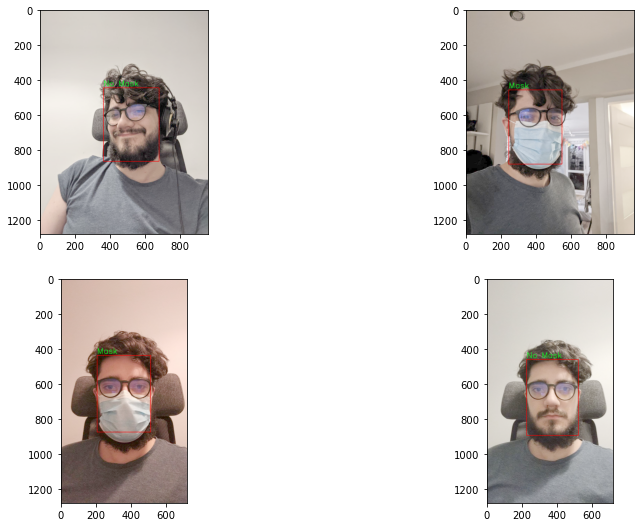

In [52]:
test_images = ['1.jpg','2.jpg','3.jpg', '4.jpg']

gamma = 2.0
fig = plt.figure(figsize = (14,14))
rows = 3
cols = 2
axes = []
assign = {'0':'Mask','1':"No Mask"}
for j,im in enumerate(test_images):
    image =  cv2.imread(os.path.join('pictures',im),1)
    print(image)
    image =  adjust_gamma(image, gamma=gamma)
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300,300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    cvNet.setInput(blob)
    detections = cvNet.forward()
    for i in range(0, detections.shape[2]):
        try:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            frame = image[startY:endY, startX:endX]
            confidence = detections[0, 0, i, 2]
            if confidence > 0.2:
                im = cv2.resize(frame,(img_size,img_size))
                im = np.array(im)/255.0
                im = im.reshape(1,124,124,3)
                result = model.predict(im)
                if result>0.5:
                    label_Y = 1
                else:
                    label_Y = 0
                cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
                cv2.putText(image,assign[str(label_Y)] , (startX, startY-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (36,255,12), 2)
        
        except:pass
    axes.append(fig.add_subplot(rows, cols, j+1))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()